In [4]:
import pandas as pd
import numpy as np
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from textblob import TextBlob
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from keras import layers

Loading data

In [3]:
nasdaq = pd.read_csv("nasdaqdata.csv")

In [4]:
tweets = pd.read_excel("TweetsScrapped.xlsx")

Creating flags and initial treatment

In [5]:
nasdaq['Date'] = pd.to_datetime(nasdaq['Date'], format='%b %d, %Y')

In [6]:
nasdaq = nasdaq.sort_values(by='Date', ascending=True).reset_index(drop=True)

In [7]:
# Crear una columna 'Tendencia' con el valor por defecto 'Sin Cambio'
nasdaq['Tendence'] = 'Sin Cambio'
nasdaq['Tendence'][0] = 1
# Calcular la tendencia en base a la cotización del día anterior
for i in range(1, len(nasdaq)):
    if nasdaq['Close'].iloc[i] > nasdaq['Close'].iloc[i - 1]:
        nasdaq['Tendence'].iloc[i] = 1
    elif nasdaq['Close'].iloc[i] < nasdaq['Close'].iloc[i - 1]:
        nasdaq['Tendence'].iloc[i] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [8]:
nasdaq

,Date,Close,Tendence
0,2022-01-03,"15,832.80",1
1,2022-01-04,"15,622.72",0
2,2022-01-05,"15,100.17",0
3,2022-01-06,"15,080.86",0
4,2022-01-07,"14,935.90",0
...,...,...,...
246,2022-12-23,"10,497.86",1
247,2022-12-27,"10,353.23",0
248,2022-12-28,"10,213.29",0
249,2022-12-29,"10,478.09",1


In [9]:
tweets['Fecha_2'] = pd.to_datetime(tweets['Fecha_2'], format='%b %d, %Y')

In [10]:
tweets_new = tweets[['Tweets', 'Fecha_2']]

In [11]:
tweets_new

,Tweets,Fecha_2
0,FIRE #shinja $shinja,2022-01-01
1,2021 returns:\n\n• Ethereum: 403% \n• Bitcoin:...,2022-01-01
2,Let's make the biggest comeback ever in 2022 #...,2022-01-01
3,Best coin,2022-01-01
4,@NSAVTech & @Vagabondappio : Another vertical ...,2022-01-01
...,...,...
19826,The Nasdaq had its worst year since 2008. Thes...,2022-12-31
19827,The year in stock indexes:\n\n—Dow Jones 30: ...,2022-12-31
19828,The @SECGov recently approved @NasdaqExchange’...,2022-12-31
19829,Client protection begins with account securit...,2022-12-31


In [12]:
df_final = pd.merge(tweets_new, nasdaq, left_on='Fecha_2', right_on='Date', how='inner')

In [13]:
df_final = df_final[['Date', 'Tweets', 'Tendence']]

Model

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pabloneira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# Paso 1: Limpieza y preprocesamiento de texto
df_final['Tweets'] = df_final['Tweets'].str.lower()  # Convertir a minúsculas
df_final['Tweets'] = df_final['Tweets'].str.replace('[^a-zA-Z\s]', '', regex=True)  # Eliminar caracteres especiales y números
df_final['Tweets'] = df_final['Tweets'].str.split()  # Tokenización
stop_words = set(stopwords.words('english'))
df_final['Tweets'] = df_final['Tweets'].apply(lambda x: [word for word in x if word not in stop_words])  # Eliminar stopwords

In [16]:
# Paso 2: Agregación de tweets por día
df_final = df_final.groupby('Date').agg({'Tweets': 'sum', 'Tendence': 'first'}).reset_index()

In [17]:
df_final

,Date,Tweets,Tendence
0,2022-01-03,"[risk, dow, spx, nasdaq, russell, fang, igopen...",1
1,2022-01-04,"[friction, gone, app, difference, rob, wasnt, ...",0
2,2022-01-05,"[key, potential, support, levels, watch, year,...",0
3,2022-01-06,"[thanks, nasdaq, looking, forward, day, announ...",0
4,2022-01-07,"[fed, balance, sheet, vs, nasdaq, amd, fb, ide...",0
...,...,...,...
246,2022-12-23,"[horrible, lot, accomplished, chipotle, huge, ...",1
247,2022-12-27,"[non, stop, volt, voltichange, imagine, catchi...",0
248,2022-12-28,"[nasdaq, sound, uk, nwbo, back, big, board, ny...",0
249,2022-12-29,"[deflationary, risk, market, x, sales, start, ...",1


In [18]:
# Paso 3: Análisis de sentimiento agregado
def get_sentiment(text):
    analysis = TextBlob(' '.join(text))
    return analysis.sentiment.polarity

df_final['Sentiment'] = df_final['Tweets'].apply(get_sentiment)

In [19]:
import pandas as pd
from collections import Counter

# Supongamos que tienes un DataFrame llamado 'df' con una columna 'tokenized_tweets'.
# Puedes combinar todas las listas de palabras en una sola lista.

all_words = []
for word_list in df_final['Tweets']:
    all_words.extend(word_list)

# Luego, cuentas la frecuencia de cada palabra.
word_counts = Counter(all_words)

# Puedes obtener las 10 palabras más comunes.
top_10_words = word_counts.most_common(10)

# 'top_10_words' contendrá una lista de tuplas, donde cada tupla es (palabra, frecuencia).

# Si deseas imprimir las palabras más comunes:
for word, frequency in top_10_words:
    print(f'{word}: {frequency}')


nasdaq: 14497
sp: 2688
stocks: 1842
market: 1745
dow: 1706
today: 1423
us: 1315
day: 1214
points: 1016
since: 963


In [21]:
# Paso 4: Separar los datos en conjuntos de entrenamiento y prueba
X = df_final['Sentiment'].values
y = df_final['Tendence'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
y_train

array([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0])

In [25]:
# Paso 5: Creación de la red neuronal
model = Sequential()
model.add(Dense(64, input_dim=1, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X = df_final[['Sentiment']]
y = df_final['Tendence']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar los clasificadores
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}

# Entrenar y evaluar cada clasificador
results = {}

for name, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Bajista', 'Alcista'])
    results[name] = {'Accuracy': accuracy, 'Classification Report': report}

# Mostrar resultados
for name, result in results.items():
    print(f'**{name}**')
    print(f'Accuracy: {result["Accuracy"]:.2f}')
    print('Classification Report:')
    print(result['Classification Report'])
    print('\n')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:230: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-

**Random Forest**
Accuracy: 0.49
Classification Report:
              precision    recall  f1-score   support

     Bajista       0.44      0.52      0.48        23
     Alcista       0.54      0.46      0.50        28

    accuracy                           0.49        51
   macro avg       0.49      0.49      0.49        51
weighted avg       0.50      0.49      0.49        51



**Support Vector Machine**
Accuracy: 0.45
Classification Report:
              precision    recall  f1-score   support

     Bajista       0.45      1.00      0.62        23
     Alcista       0.00      0.00      0.00        28

    accuracy                           0.45        51
   macro avg       0.23      0.50      0.31        51
weighted avg       0.20      0.45      0.28        51



**Logistic Regression**
Accuracy: 0.45
Classification Report:
              precision    recall  f1-score   support

     Bajista       0.45      1.00      0.62        23
     Alcista       0.00      0.00      0.00       

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
# Paso 6: Entrenamiento del modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=700, batch_size=128)

Epoch 1/700
2/2 [==============================] - 1s 4ms/step - loss: 0.6929 - accuracy: 0.4550
Epoch 2/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6910 - accuracy: 0.6300
Epoch 3/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6893 - accuracy: 0.5850
Epoch 4/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5850
Epoch 5/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6864 - accuracy: 0.5850
Epoch 6/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.5850
Epoch 7/700
2/2 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.5850
Epoch 8/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6826 - accuracy: 0.5850
Epoch 9/700
2/2 [==============================] - 0s 4ms/step - loss: 0.6815 - accuracy: 0.5850
Epoch 10/700
2/2 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.5850
Epoch 11/700
2/2 [===========

2/2 [==============================] - 0s 3ms/step - loss: 0.6428 - accuracy: 0.6050
Epoch 167/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6427 - accuracy: 0.6050
Epoch 168/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6050
Epoch 169/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6423 - accuracy: 0.6100
Epoch 170/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6100
Epoch 171/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6422 - accuracy: 0.6100
Epoch 172/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6050
Epoch 173/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6420 - accuracy: 0.6000
Epoch 174/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6000
Epoch 175/700
2/2 [==============================] - 0s 2ms/step - loss: 0.6417 - accuracy: 0.6000
Epoch 176/700
2/2 [=====

2/2 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6050
Epoch 331/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6050
Epoch 332/700
2/2 [==============================] - 0s 2ms/step - loss: 0.6375 - accuracy: 0.6050
Epoch 333/700
2/2 [==============================] - 0s 6ms/step - loss: 0.6375 - accuracy: 0.6050
Epoch 334/700
2/2 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6050
Epoch 335/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6050
Epoch 336/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6100
Epoch 337/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6100
Epoch 338/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6050
Epoch 339/700
2/2 [==============================] - 0s 4ms/step - loss: 0.6373 - accuracy: 0.6000
Epoch 340/700
2/2 [=====

2/2 [==============================] - 0s 2ms/step - loss: 0.6374 - accuracy: 0.6100
Epoch 495/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6100
Epoch 496/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6050
Epoch 497/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6050
Epoch 498/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6050
Epoch 499/700
2/2 [==============================] - 0s 2ms/step - loss: 0.6372 - accuracy: 0.6050
Epoch 500/700
2/2 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.6050
Epoch 501/700
2/2 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6050
Epoch 502/700
2/2 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6050
Epoch 503/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6374 - accuracy: 0.6050
Epoch 504/700
2/2 [=====

2/2 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6050
Epoch 659/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6050
Epoch 660/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6375 - accuracy: 0.6050
Epoch 661/700
2/2 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.6050
Epoch 662/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6050
Epoch 663/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6050
Epoch 664/700
2/2 [==============================] - 0s 4ms/step - loss: 0.6375 - accuracy: 0.6050
Epoch 665/700
2/2 [==============================] - 0s 4ms/step - loss: 0.6376 - accuracy: 0.6050
Epoch 666/700
2/2 [==============================] - 0s 3ms/step - loss: 0.6373 - accuracy: 0.6050
Epoch 667/700
2/2 [==============================] - 0s 4ms/step - loss: 0.6374 - accuracy: 0.6050
Epoch 668/700
2/2 [=====

In [27]:
# Paso 7: Evaluación del modelo
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Umbral de 0.5 para convertir a etiquetas binarias
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.87      0.71        23
           1       0.83      0.54      0.65        28

    accuracy                           0.69        51
   macro avg       0.72      0.70      0.68        51
weighted avg       0.73      0.69      0.68        51



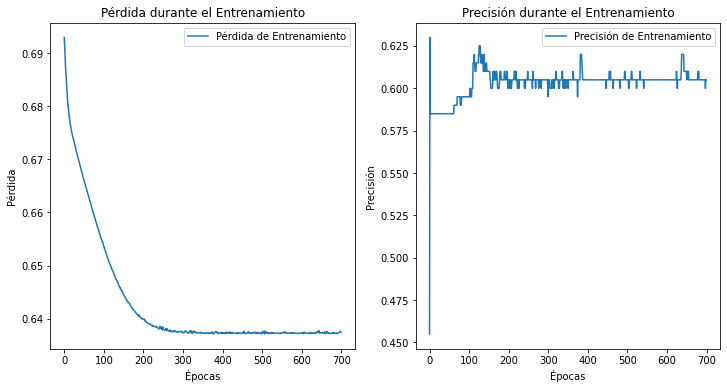

In [28]:
# Visualizar la pérdida y la precisión durante el entrenamiento
plt.figure(figsize=(12, 6))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')

plt.show()

In [29]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')

Precisión del modelo: 0.69


In [30]:
df_final['Tendence'].value_counts()

0    140
1    111
Name: Tendence, dtype: int64

In [94]:
# Crear una función que construye el modelo
def create_model(neurons=16, activation='relu'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=1, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [97]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
# Crear un modelo basado en KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Definir los hiperparámetros a optimizar
param_grid = {
    'neurons': [16, 32, 64],  # Prueba con diferentes números de neuronas
    'activation': ['relu', 'tanh', 'sigmoid'],  # Prueba diferentes funciones de activación
    'batch_size': [32, 64, 128],  # Prueba diferentes tamaños de lote
    'epochs': [1000]  # Prueba diferentes números de épocas
}

# Realizar la búsqueda de hiperparámetros
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print(f"Mejor precisión: {grid_result.best_score_:.4f} usando {grid_result.best_params_}")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Mejor precisión: 0.6650 usando {'activation': 'tanh', 'batch_size': 128, 'epochs': 1000, 'neurons': 64}


In [21]:
from tensorflow import keras
model = keras.models.load_model("model.h5")# Define el diseño de la página

In [22]:
import tkinter as tk
from textblob import TextBlob  # Asegúrate de tener instalada la biblioteca TextBlob
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from PIL import Image, ImageTk


In [66]:
# Descarga las stopwords si aún no lo has hecho
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def get_sentiment(text):
    # Paso 1: Limpieza y preprocesamiento de texto
    text = text.lower()  # Convertir a minúsculas
    text = re.sub('[^a-zA-Z\s]', '', text)
    tokens = text.split()  # Tokenización
    tokens = [word for word in tokens if word not in stop_words]  # Eliminar stopwords

    cleaned_text = ' '.join(tokens)

    analysis = TextBlob(cleaned_text)
    return analysis.sentiment.polarity

def predecir_sentimiento():
    tweet = tweet_entry.get()
    sentiment = get_sentiment(tweet)
    prediction = model.predict([sentiment])
    resultado = "Sube" if prediction >= 0.5 else "Baja"  # Ajusta esto según tu modelo

    resultado_label.config(text=f"Predicción: {resultado}")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pabloneira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
# Crear la ventana principal
ventana = tk.Tk()
ventana.title("NASDAQ PREDICTION BY TWEETS")


# Etiqueta y entrada para el tweet
tweet_label = tk.Label(ventana, text="Ingrese un tweet:")
tweet_label.pack()
tweet_entry = tk.Entry(ventana)
tweet_entry.pack()

# Botón para realizar la predicción
prediccion_button = tk.Button(ventana, text="Obtener Predicción", command=predecir_sentimiento)
prediccion_button.pack()

# Etiqueta para mostrar la predicción
resultado_label = tk.Label(ventana, text="")
resultado_label.pack()

ventana.mainloop()

In [24]:
def get_sentiment(text):
    # Paso 1: Limpieza y preprocesamiento de texto
    text = text.lower()  # Convertir a minúsculas
    text = re.sub('[^a-zA-Z\s]', '', text)  # Eliminar caracteres especiales y números
    tokens = text.split()  # Tokenización
    tokens = [word for word in tokens if word not in stop_words]  # Eliminar stopwords

    cleaned_text = ' '.join(tokens)

    analysis = TextBlob(cleaned_text)
    return analysis.sentiment.polarity

In [26]:
import tkinter as tk
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from textblob import TextBlob
from PIL import Image, ImageTk

# Descarga las stopwords si aún no lo has hecho
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def get_sentiment(text):
    # Paso 1: Limpieza y preprocesamiento de texto
    text = text.lower()  # Convertir a minúsculas
    text = re.sub('[^a-zA-Z\s]', '', text)  # Eliminar caracteres especiales y números
    tokens = text.split()  # Tokenización
    tokens = [word for word in tokens if word not in stop_words]  # Eliminar stopwords

    cleaned_text = ' '.join(tokens)

    analysis = TextBlob(cleaned_text)
    return analysis.sentiment.polarity

def set_background():
    global background_photo
    background_label = tk.Label(ventana, image=background_photo)
    background_label.place(relwidth=1, relheight=1)

def set_logo():
    global logo_photo
    logo_label = tk.Label(ventana, image=logo_photo)
    logo_label.place(x=10, y=10)

def predecir_sentimiento():
    tweet = tweet_entry.get("1.0", "end-1c")  # Obtener todo el contenido del widget Text
    sentiment = get_sentiment(tweet)
    prediction = model.predict([sentiment])
    resultado = "Sube" if prediction >= 0.5 else "Baja"  # Ajusta esto según tu modelo

    resultado_label.config(text=f"Predicción: {resultado}", font=("Helvetica", 16, "bold"))

# Crear la ventana principal
ventana = tk.Tk()
ventana.title("Predicción de Sentimiento en Twitter")

# Personalizar el fondo de la ventana
ventana.configure(bg="#1DA1F2")  # Color de fondo similar al color de Twitter

# Ajustar el tamaño de la ventana
ventana.geometry("600x400")  # Aumentar el tamaño de la ventana

# Etiqueta y entrada para el tweet
tweet_label = tk.Label(ventana, text="Ingresa un tweet:", fg="white", bg="#1DA1F2", font=("Helvetica", 16, "bold"))  # Aumentar el tamaño de fuente
tweet_label.pack(pady=10)

tweet_entry = tk.Text(ventana, font=("Helvetica", 14), height=4, wrap=tk.WORD)  # Utilizar el widget Text para entrada de varias líneas
tweet_entry.pack(padx=10, pady=10)

# Botón para realizar la predicción
prediccion_button = tk.Button(ventana, text="Obtener Predicción", command=predecir_sentimiento, bg="#1DA1F2", fg="black", font=("Helvetica", 14, "bold"))  # Aumentar el tamaño de fuente
prediccion_button.pack(pady=10)

# Etiqueta para mostrar la predicción
resultado_label = tk.Label(ventana, text="", fg="white", bg="#1DA1F2", font=("Helvetica", 16, "bold"))
resultado_label.pack(pady=10)

ventana.mainloop()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pabloneira/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
